In [309]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
    ensemble,
    preprocessing,
    tree,
)

from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC,
)

from yellowbrick.model_selection import (
    LearningCurve,
)

from pathlib import Path

In [310]:
ROOT_FILE = Path.cwd().parent
DATA_FILE = ROOT_FILE / "datasets" / "titanic3.csv"

Yellow Brick é uma biblioteca de visualização e diagnóstico para aprendizado de máquina que visa capacitar os usuários a visualizar os processos internos de seus modelos de aprendizado de máquina e permitir que eles tomem decisões mais informadas durante o processo de modelagem, facilitando a compreensão das forças e fraquezas de seus modelos.

## Faça uma pergunta

Essa corresponde a primeira etapa do processo de machine learning, onde você deve se perguntar o que deseja descobrir com os dados que possui. Para o exemplo do livro, será criado um modelo preditivo para responder uma pergunta: O indivíduo sobreviveu ou não ao naufrágio do Titanic? Terá-se como base os dados de passageiros do navio, como idade, sexo, classe social, etc.

É uma pergunta de classificação, pois estamos fazendo a predição de um rotulo, que é a sobrevivência ou não do passageiro. Se fosse uma pergunta de regressão, seria algo como: Qual a idade do passageiro?

## Colete os dados

A segunda etapa é a coleta dos dados, que pode ser feita de diversas formas, como por exemplo, através de um web crawler, que é um programa que navega pela web e coleta os dados de interesse. Pode ser feita pelo download de um dataset, como o do Kaggle, ou até mesmo através de uma API.

Para o exemplo do livro, estou mostrando duas maneiras, uma através de uma URL e outra através do download de um dataset.

In [311]:
url = ("https://hbiostat.org/data/repo/titanic3.csv")
df = pd.read_csv(url)

## OU

df = pd.read_csv(DATA_FILE)

df_orig = pd.read_csv(DATA_FILE)


Tem-se os seguintes dados:

- **pclass**: Classe do passageiro (1 = primeira classe; 2 = segunda classe; 3 = terceira classe)

- **survived**: Sobreviveu ou não (0 = Não; 1 = Sim)

- **name**: Nome do passageiro

- **sex**: Sexo do passageiro

- **age**: Idade do passageiro

- **sibsp**: Número de irmãos e cônjuges a bordo

- **parch**: Número de pais e filhos a bordo

- **ticket**: Número do ticket

- **fare**: Tarifa do passageiro

- **cabin**: Número da cabine

- **embarked**: Porto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton)

- **boat**: Bote salva-vidas

- **body**: Número de identificação do corpo

- **home.dest**: Destino

## Limpe os dados

A maioria dos modelo do scikit-learn exige que os dados sejam numéricos. Os modelos podem falhar caso recebam valores ausentes. Além disso alguns modelos podem ter melhores desempenhos se os dados estiverem padronizados.

Podem também existir os chamados leaky features(dados que vazam informações). Essas variaveis contém informações sobre o futuro ou o resultado que se deseja prever

In [312]:
df.dtypes # Verificando os tipos de dados

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

Os tipos de dados mais comuns são:

- **int64**: Números inteiros

- **float64**: Números reais

- **datetime64[ns]**: Data e hora

- **object**: String, mas pode ser uma combinação entre strings e outros tipos

No geral tipos inteiros não apresentam problemas. Tipos float podem apresentar problemas com valores ausentes. Tipos data e string deverão ser convertidos para números.

Tipos string com baixa cardinalidade (poucos valores únicos) são chamados de colunas de categoria, é possível gerar colunas dummy (binárias) para cada valor único

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Temos 6 variaveis númericas, 7 variaveis categóricas e 1 variavel booleana

In [314]:
df.shape # Verificando o tamanho do dataset

(1309, 14)

In [315]:
df.describe() # Verificando as estatísticas do dataset

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [316]:
df.describe().iloc[:, :2] # iloc é um método para selecionar 
# linhas e colunas por números inteiros. Neste caso, estamos
# selecionando todas as linhas e as duas primeiras colunas

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


- **count:**  quantidade de valores não nulos

- **mean:** média dos valores

- **std:** desvio padrão

- **min:** valor mínimo

- **25%:** primeiro quartil

- **50%:** segundo quartil (mediana)

- **75%:** terceiro quartil

- **max:** valor máximo

Count é interessa para identificar valores ausentes. A mediana é mais robusta que a média, pois não é afetada por outliers.

Min e máx são importantes para identificar outliers. O desvio padrão é uma medida de dispersão, quanto maior o desvio padrão, maior a dispersão dos dados.

```python

df.isnull() # retorna um dataframe com valores booleanos, onde True indica que o valor é nulo

df.isnull().sum() # retorna a soma dos valores nulos de cada coluna

```

In [317]:
df.isnull().sum() # Verificando a quantidade de valores nulos

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

```python

df.isnull().mean() # Verificando a porcentagem de valores nulos

```

Útil para identificar colunas com muitos valores nulos

In [318]:
df.isnull().sum(axis=1).loc[:10] # Verificando a quantidade de valores nulos por linha

0     1
1     1
2     2
3     1
4     2
5     1
6     1
7     2
8     1
9     2
10    1
dtype: int64

A coluna body deve ser removida pois contém muitos valores nulos e pode ser considerada uma leaky feature (informa que o passageiro morreu).

A coluna boat também deve ser removida pois contém muitos valores nulos e pode ser considerada uma leaky feature (informa que o passageiro sobreviveu).


In [319]:
mask = df.isnull().any(axis = 1) # Criando uma máscara para selecionar as linhas com valores nulos
# any é um método que retorna True se qualquer elemento do eixo for True
mask.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [320]:
df[mask].body.head()

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64

In [321]:
df.sex.value_counts() # Verificando a quantidade de valores por categoria

sex
male      843
female    466
Name: count, dtype: int64

In [322]:
df.embarked.value_counts(dropna=False) # Verificando a quantidade de valores por categoria, incluindo os valores nulos

embarked
S      914
C      270
Q      123
NaN      2
Name: count, dtype: int64

Temos 2 valores nulos na coluna embarked, podemos substituir pela moda (valor mais frequente), remover a linha, ou criar um dummy, ou então substituir pela média.

#### Criando os atributos

In [323]:
name = df['name']
# ou
name = df.name
name.head(3)

0     Allen, Miss. Elisabeth Walton
1    Allison, Master. Hudson Trevor
2      Allison, Miss. Helen Loraine
Name: name, dtype: object

In [324]:
df = df.drop(
    columns=[
        'name',
        'ticket',
        'home.dest',
        'boat',
        'body',
        'cabin',
    ]
)

Utiliza-se o método `drop` para remover linhas ou colunas, o padrão é remover linhas, para remover colunas, deve-se passar o parâmetro `axis=1`.

Remove-se, então: name, ticket, cabin, boat, body e home.dest

boat e body são leaky features, pois informam se o passageiro sobreviveu ou não

name, ticket e cabin são colunas de alta cardinalidade, ou seja, possuem muitos valores únicos, o que pode dificultar o aprendizado do modelo

home.dest é uma coluna de baixa cardinalidade, mas não é relevante para o modelo

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.9+ KB


In [326]:
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   survived    1309 non-null   int64  
 2   age         1046 non-null   float64
 3   sibsp       1309 non-null   int64  
 4   parch       1309 non-null   int64  
 5   fare        1308 non-null   float64
 6   sex_female  1309 non-null   bool   
 7   sex_male    1309 non-null   bool   
 8   embarked_C  1309 non-null   bool   
 9   embarked_Q  1309 non-null   bool   
 10  embarked_S  1309 non-null   bool   
dtypes: bool(5), float64(2), int64(4)
memory usage: 67.9 KB


Utiliza-se `pd.get_dummies` para criar colunas dummy para as colunas categóricas

Essas colunas dummy são binárias, ou seja, possuem apenas 2 valores, 0 ou 1


In [327]:
df = df.drop(columns='sex_male')

Remove-se a coluna sex_male, pois ela é inversa a coluna sex_female. Se o valor de uma for 0, o valor da outra será 1 e vice-versa. Esse tipo de relação é chamada de correlação perfeita negativa. Essas relações podem causar problemas no modelo, pois o modelo pode entender que uma coluna é mais importante que a outra, quando na verdade elas são iguais.

In [328]:
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

Passando o parâmetro `drop_first=True` para `pd.get_dummies`, a primeira coluna dummy será removida, evitando assim a correlação perfeita negativa.

In [329]:
X = df.drop(columns='survived')
y = df.survived

```python
X = df.drop(columns='survived')
y = df['survived']
```

X é um dataframe com todas as colunas, exceto a coluna survived

y é uma série com a coluna survived


#### Separando as amostras

In [330]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)

O método `train_test_split` separa os dados em amostras de treino e teste. O parâmetro `test_size` define a porcentagem de dados que serão separados para teste, o padrão é 25%. Para o exemplo está sendo utilizado 30%, o que quer dizer que 70% dos dados são para treino e 30% para teste.

O parametro `random_state` define a semente do gerador de números aleatórios, isso garante que a separação dos dados seja sempre a mesma, ou seja, sempre que o código for executado, os mesmos dados serão separados para treino e teste.

`X_train` é um dataframe contendo 70% dos dados de X

`X_test` é um dataframe contendo 30% dos dados de X

`y_train` é uma série contendo 70% dos dados de y

`y_test` é uma série contendo 30% dos dados de y


#### Faça a imputação dos dados

In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   survived    1309 non-null   int64  
 2   age         1046 non-null   float64
 3   sibsp       1309 non-null   int64  
 4   parch       1309 non-null   int64  
 5   fare        1308 non-null   float64
 6   sex_female  1309 non-null   bool   
 7   embarked_C  1309 non-null   bool   
 8   embarked_Q  1309 non-null   bool   
 9   embarked_S  1309 non-null   bool   
dtypes: bool(4), float64(2), int64(4)
memory usage: 66.6 KB


In [332]:
from sklearn import impute

In [333]:
num_cols = [
    'pclass',
    'age',
    'sibsp',
    'parch',
    'fare',
]

In [334]:
from sklearn.experimental import enable_iterative_imputer
imputer = impute.IterativeImputer()

imputed = imputer.fit_transform(
    X_train[num_cols]
)
X_train.loc[:, num_cols] = imputed

imputed = imputer.transform(
    X_test[num_cols]
)
X_test.loc[:, num_cols] = imputed

nan_values_x_train = X_train.isnull().sum()
nan_values_x_test = X_test.isnull().sum()

print(f'O numero de valores nulos no X_train é: {nan_values_x_train.sum()}'\
      f'\nO numero de valores nulos no X_test é: {nan_values_x_test.sum()}')

O numero de valores nulos no X_train é: 0
O numero de valores nulos no X_test é: 0


Uma das formas de lidar com esses valores nulos é através da imputação, que é a substituição dos valores nulos por outros valores. Foi utilizada a biblioteca `sklearn.impute` para fazer a imputação.

Inicialmente cria-se uma variavel `num_cols`  com as colunas numéricas.

Em seguida cria-se `imputer` com o método `impute.IterativeImputer()`, ou seja `imputer` é um objeto da classe `IterativeImputer`.

Cria-se em sequência a variavel `imputed` através `imputer.fit_transform(X_tra[num_cols]`, ou seja, `imputed` é um array numpy com os valores imputados.

Em sequência é feita a indexação de `imputed` para `X_train[num_cols]` e `X_test[num_cols]`, ou seja, os valores imputados são atribuidos a `X_train[num_cols]` e `X_test[num_cols]`.



In [335]:
meds = X_train.median()

X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)

nan_values_x_train = X_train.isnull().sum()
nan_values_x_test = X_test.isnull().sum()

print(f'O numero de valores nulos no X_train é: {nan_values_x_train.sum()}'\
        f'\nO numero de valores nulos no X_test é: {nan_values_x_test.sum()}')

O numero de valores nulos no X_train é: 0
O numero de valores nulos no X_test é: 0


De modo semelhante pode-se imputar valores utilizando a mediana por exemplo.

Cria-se uma variavel chamada `meds`, ela recebe a mediana de `X_train`, e em sequência utiliza-se o método `fillna` para substituir os valores nulos de `X_train` e `X_test` pela mediana.

### Normalize os dados

In [336]:
from sklearn import preprocessing

cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
   'embarked_Q', 'embarked_S']
sca = preprocessing.StandardScaler()
X_train = sca.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = sca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

### Refatore

In [337]:
def tweaky_titanic (df) -> pd.DataFrame:
    df.drop(
        columns=[
            'name',
            'ticket',
            'home.dest',
            'boat',
            'body',
            'cabin',
        ],
    ).pipe(pd.get_dummies, drop_first=True)
    return df

A função `.pipe` permite encadear funções, ou seja, o resultado de uma função é passado como parâmetro para a próxima função.

O parâmetro `drop_first=True` é passado para `pd.get_dummies` através de `.pipe`, evitando assim a correlação perfeita negativa.

Uma breve explicação sobre a função `tweaky_titanic` :

```python

def tweaky_titanic (df):
    df.drop(
        columns=[
            'name',
            'ticket',
            'home.dest',
            'boat',
            'body',
            'cabin',
        ],
    ).pipe(pd.get_dummies, drop_first=True)
    return df

```

A função irá receber um data frame como parâmetro, e em seguida irá remover as colunas name, ticket, home.dest, boat, body e cabin. Em seguida irá criar colunas dummy para as colunas categóricas, e por fim irá retornar o data frame.

In [338]:
from sklearn.experimental import enable_iterative_imputer
def get_train_test_X_y (
        df, y_col, size = 0.3, std_cols = None
):
    y = df[y_col]
    X = df.drop(columns=y_col)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=size,
        random_state=42,
    )

    cols = X.columns
    num_cols = [
        'pclass',
        'age',
        'sibsp',
        'parch',
        'fare',
    ]
    
    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(
        X_train[num_cols]
    )

    X_test.loc[:, num_cols] = fi.transform(
        X_test[num_cols]
    )

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(
            X_train[std_cols]
        )

        X_test.loc[:, std_cols] = std.transform(
            X_test[std_cols]
        )

    return X_train, X_test, y_train, y_test


Explicação sobre a função `get_train_text_X_y` :

```python
from sklearn.experimental import enable_iterative_imputer
def get_train_test_X_y (
        df, y_col, size = 0.3, std_cols = None
):
    y = df[y_col]
    X = df.drop(columns=y_col)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=size,
        random_state=42,
    )

    cols = X.columns
    num_cols = [
        'pclass',
        'age',
        'sibsp',
        'parch',
        'fare',
    ]
    
    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(
        X_train[num_cols]
    )

    X_test.loc[:, num_cols] = fi.transform(
        X_test[num_cols]
    )

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(
            X_train[std_cols]
        )

        X_test.loc[:, std_cols] = std.transform(
            X_test[std_cols]
        )

    return X_train, X_test, y_train, y_test

```

Inicia-se importando a classe `IterativeImputer` da biblioteca `sklearn.experimental`, essa classe permite fazer a imputação dos dados.

A função recebe como parâmetro um data frame, o nome da coluna alvo, o tamanho da amostra de teste, e uma lista com as colunas que serão padronizadas.

Em seguida é feita a separação dos dados em amostras de treino e teste.

Em seguida é criada uma lista com as colunas numéricas.

Em seguida é criado um objeto da classe `IterativeImputer` e em seguida é feita a imputação dos dados de treino e teste.

Em seguida é feita a padronização dos dados de treino e teste.

A padronização é feita através da classe `StandardScaler` da biblioteca `sklearn.preprocessing`. Ela so é feita se o parâmetro `std_cols` for diferente de `None`.

Por fim a função retorna os dados de treino e teste.


In [339]:
ti_df = tweaky_titanic(df_orig)

std_cols = "pclass, age, sibsp, parch, fare".split(", ")

X_train, X_test, y_train, y_test = get_train_test_X_y(
    df, "survived", std_cols=std_cols
)

Explicação do código acima:

```python

ti_df = tweaky_titanic(df_orig)

std_cols = "pclass, age, sibsp, parch, fare".split(", ")

X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

```

A variavel `ti_df` recebe o resultado da função `tweaky_titanic` que recebe como parâmetro o data frame original.

A variavel `std_cols` recebe uma lista com as colunas que serão padronizadas.

Em seguida as variaveis `X_train, X_test, y_train, y_test` recebem o resultado da função `get_train_test_X_y` que recebe como parâmetro o data frame `ti_df`, o nome da coluna alvo, e a lista com as colunas que serão padronizadas.

```

### Modelo de base

O modelo de base é um modelo simples que será utilizado como base para comparação com outros modelos mais complexos.

Utilizar ```.score``` pode acarretar em previsões inválidas. Por isso fazer uso do modelo de base como comparação é uma boa prática.

In [340]:
from sklearn.dummy import DummyClassifier

bm = DummyClassifier(strategy='most_frequent')
bm.fit(X_train, y_train)
bm.score(X_test, y_test)
print(f'A acurácia do modelo DummyClassifier é: {round(bm.score(X_test, y_test),2)}')

A acurácia do modelo DummyClassifier é: 0.57


Explicação do código acima:

```python

from sklearn.dummy import DummyClassifier

bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test)

```

A variavel `bm` recebe um objeto da classe `DummyClassifier` da biblioteca `sklearn.dummy`. Essa classe cria um modelo que faz previsões aleatórias.

Em seguida é feito o treinamento do modelo através do método `fit` e em seguida é feita a previsão através do método `score`.

O resultado é 0.55, ou seja, o modelo acerta 55% das previsões.

In [351]:
from sklearn import metrics

precision = metrics.precision_score(y_test, bm.predict(X_test), zero_division=0)

print(precision)

0.0


Explicação do código acima:

```python

from sklearn import metrics

precision = metrics.precision_score(y_test, bm.predict(X_test), zero_division=0)

```

A função `precision_score` da biblioteca `sklearn.metrics` calcula a precisão do modelo, ou seja, a quantidade de previsões corretas dividido pela quantidade de previsões totais.

O resultado é 0.0 pois o acarretou em uma divisão por zero.


### Varias famílias de modelos

A biblioteca `sklearn` possui diversas famílias de modelos, cada uma com suas vantagens e desvantagens. É importante testar várias famílias de modelos para encontrar a que melhor se adequa ao problema.

Um teorema chamado de teorema de No Free Lunch diz que não existe um modelo que seja melhor para todos os problemas. Por isso é importante testar várias famílias de modelos.

Definiremos para o modelo acima como base e testaremos o AUC de outros modelos.

In [342]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

A função `pd.concat` concatena data frames, por exemplo `pd.concat([df1, df2])` irá concatenar os data frames `df1` e `df2`.

In [343]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [344]:
X_encoded = pd.get_dummies(X)

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

kfold = KFold(n_splits=10, random_state=42, shuffle=True)

Como mencionado anteriormente, o `pd.get_dummies()` cria colunas dummy. Dummy seria o mesmo que boneco de pano, ou seja, é uma coluna que não possui valor real, apenas 0 ou 1.

`imputer` é um objeto da classe `SingleImputer`, a instância `strategy` é um objeto da classe `SimpleImputer` que recebe como parâmetro a estratégia de imputação, que no caso é a média.

`X_imputed` recebe o resultado de `imputer.fit_transform(X_encoded)`, ou seja `X_imputed` é um array numpy com os valores imputados. Entretanto isto está dentro da função `pd.DataFrame`, ou seja, `X_imputed` é um data frame. O parâmetro `columns` é passado para `pd.DataFrame` para que as colunas sejam mantidas.

In [345]:
models = [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    XGBClassifier,
]

`models` é uma lista com o nome dos modelos

In [346]:
for model_class in models:
    if model_class == LogisticRegression:
        model = model_class(max_iter=1000)
        scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kfold)

        print(f'{model_class.__name__:22} AUC: {scores.mean():.3f} STD: {scores.std():.2f}')
    
    elif model_class == KNeighborsClassifier:
        model = model_class(n_neighbors=10)

        scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
        print(f'{model_class.__name__:22} AUC: {scores.mean():.3f} STD: {scores.std():.2f}')

    else:

        model = model_class()


        scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kfold)
    
        print(f'{model_class.__name__:22} AUC: {scores.mean():.3f} STD: {scores.std():.2f}')

DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.840 STD: 0.04
DecisionTreeClassifier AUC: 0.763 STD: 0.03
KNeighborsClassifier   AUC: 0.782 STD: 0.03
GaussianNB             AUC: 0.804 STD: 0.04
SVC                    AUC: 0.838 STD: 0.03


RandomForestClassifier AUC: 0.850 STD: 0.02
XGBClassifier          AUC: 0.852 STD: 0.02


O laço for irá iterar sobre a lista `models`

Dentro do for tratamos duas condicionais para modelos especificos, estes são os modelos `LogisticRegression` e `KNeighborsClassifier`

Para o modelo `LogisticRegression` é necessário aumentarmos o numero de iterações para que o modelo possa convergir

Para o modelo `KNeighborsClassifier` é necessário converter `X_imputed` para um array numpy, pois o modelo não aceita data frames

Em seguida é feito a criação da váriavel `scores` que recebe `cross_val_score` que recebe como parâmetro o modelo, os dados de treino, o alvo, o número de folds e a métrica

Como pode se observar o modelo que obteve o melhor resultado foi o `LogisticRegression` com 0.982 de AUC

In [347]:
random_forest = ensemble.RandomForestClassifier( # ensemble.RandomForestClassifier é um método para criar um modelo de Random Forest
    n_estimators=100, # n_estimators é o número de árvores que serão criadas
    random_state=42, # random_state é o parâmetro que define a semente aleatória
)

random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [353]:
RandomForestClassifier( # RandomForestClassifier é um método para criar um modelo de Random Forest
    bootstrap=True, # bootstrap é um parâmetro que define se o método vai usar bootstraping ou não (amostragem com reposição)
    class_weight=None, # class_weight é um parâmetro que define o peso de cada classe
    criterion='gini',
    max_depth=None, # max_depth é um parâmetro que define a profundidade máxima de cada árvore
    max_features='auto', # max_features é um parâmetro que define a quantidade de variáveis que serão usadas para criar cada árvore
    max_leaf_nodes=None, # max_leaf_nodes é um parâmetro que define a quantidade máxima de nós folha
    min_impurity_decrease=0.0, # min_impurity_decrease é um parâmetro que define o valor mínimo para reduzir a impureza
    min_samples_leaf=1, # min_samples_leaf é um parâmetro que define a quantidade mínima de amostras em cada nó folha
    min_samples_split=2, # min_samples_split é um parâmetro que define a quantidade mínima de amostras para dividir um nó
    min_weight_fraction_leaf=0.0, # min_weight_fraction_leaf é um parâmetro que define a quantidade mínima de amostras em cada nó folha
    n_estimators=10, # n_estimators é o número de árvores que serão criadas
    n_jobs=1, # n_jobs é um parâmetro que define a quantidade de processadores que serão usados
    oob_score=False, # oob_score é um parâmetro que define se o método vai usar out-of-bag samples para estimar o R²
    random_state=42, 
    verbose=0, # verbose é um parâmetro que define se o método vai imprimir mensagens na tela
    warm_start=False, # warm_start é um parâmetro que define se o método vai usar a solução da chamada anterior para inicializar
)

RandomForestClassifier(max_features='auto', n_estimators=10, n_jobs=1,
                       random_state=42)

In [355]:
random_forest.score(X_test, y_test) # score é um método para calcular a acurácia do modelo (acertos / total)

0.7938931297709924

In [356]:
metrics.precision_score(y_test, random_forest.predict(X_test)) # precision_score é um método para calcular a precisão do modelo (tp / (tp + fp))

0.7972972972972973

In [357]:
for col, val in sorted( # sorted é um método para ordenar uma lista
    zip( # zip é um método para criar uma lista de tuplas
        X_train.columns, # X_train.columns é uma lista com os nomes das colunas
        random_forest.feature_importances_, # random_forest.feature_importances_ é uma lista com a importância de cada variável
    ),
    key= lambda x: x[1], # key é um parâmetro que define a função para ordenar a lista
    reverse=True # reverse é um parâmetro que define se a lista será ordenada em ordem crescente ou decrescente (True = decrescente)
)[:5]: # [:5] é um método para selecionar os 5 primeiros elementos da lista
    print(f'{col:10}{val:10.3f}') # :10 é um método para definir o tamanho da string

age            0.277
fare           0.265
sex_female     0.244
pclass         0.090
sibsp          0.048


É crucial a verificação da importância dos atributos. A remoção de um atributo pode ou não afetar o desempenho do modelo. A remoção de atributos irrelevantes pode melhorar o desempenho do modelo, pois o modelo não irá se basear em atributos irrelevantes.

In [366]:
random_forest_hiperparametros = ensemble.RandomForestClassifier(
    **{
        "max_features": 0.3,
        "n_estimators": 200,
        "min_samples_split": 2,
        "random_state":42
    }
)

random_forest_hiperparametros.fit(X_train, y_train) 
random_forest_hiperparametros.score(X_test, y_test) 

0.7964376590330788

## Matriz de confusão

In [367]:
from sklearn.metrics import confusion_matrix

In [368]:
y_pred = random_forest_hiperparametros.predict(X_test) 
confusion_matrix(y_test, y_pred)

array([[196,  28],
       [ 52, 117]])

/home/pcmoraes/anaconda3/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


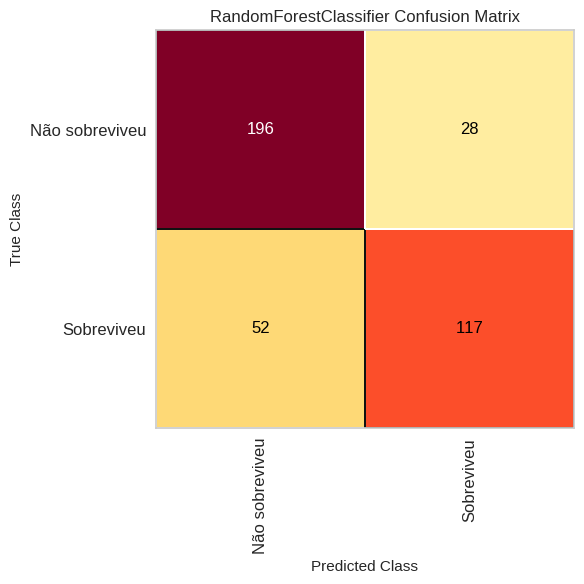

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [369]:
mapping = {
    0: "Não sobreviveu",
    1: "Sobreviveu",
}

fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    random_forest_hiperparametros,
    classes=["Não sobreviveu", "Sobreviveu"],
    label_encoder=mapping,
)

cm_viz.score(X_test, y_test)
cm_viz.poof()

## AUC

In [370]:
y_pred = random_forest_hiperparametros.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7836538461538461

In [373]:
from yellowbrick.classifier import ROCAUC


/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


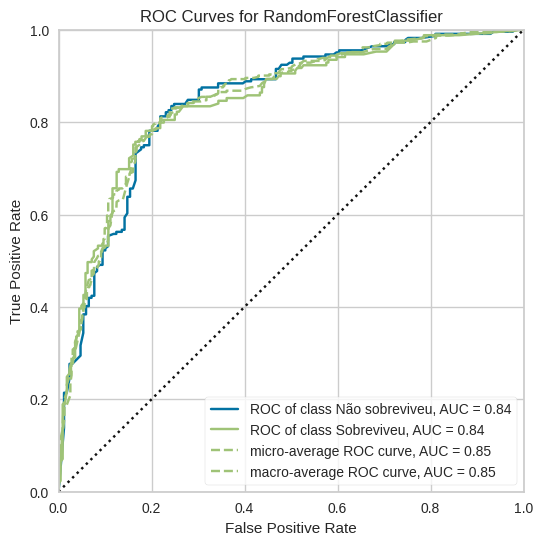

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [375]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(
    random_forest_hiperparametros,
    classes=["Não sobreviveu", "Sobreviveu"],
    label_encoder=mapping,
)

roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)

roc_viz.poof()


## Curva de Aprendizado

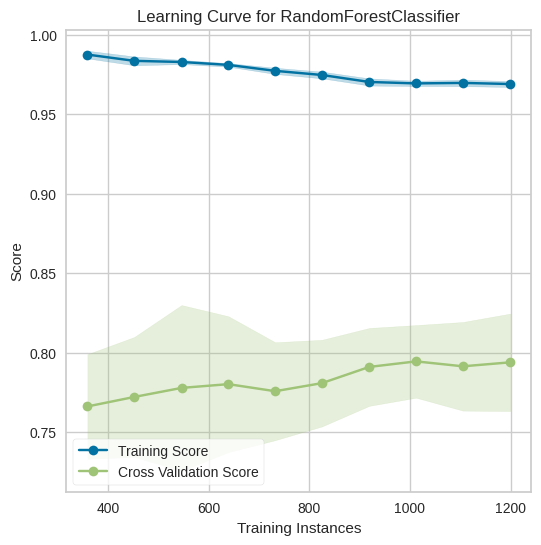

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [376]:
import numpy as np

fig, ax = plt.subplots(figsize=(6, 6))

cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)

lc_viz = LearningCurve(
    random_forest_hiperparametros,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)

lc_viz.fit(X, y)
lc_viz.poof()